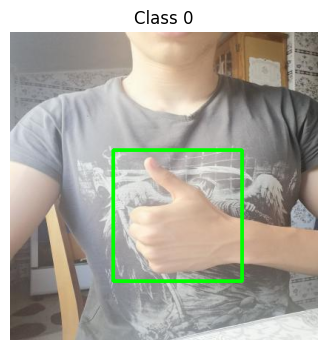

In [5]:
import cv2
import matplotlib.pyplot as plt
import os

data_path = '/content/drive/My Drive/Computer Vision Project/unaugmented/416'
images_dir = os.path.join(data_path, 'train/images')
labels_dir = os.path.join(data_path, 'train/labels')

# Get the first image
filename = sorted(os.listdir(images_dir))[0]
img_path = os.path.join(images_dir, filename)

# Get the corresponding label
txt_filename = os.path.splitext(filename)[0] + ".txt"
txt_path = os.path.join(labels_dir, txt_filename)

# Read Image
image = cv2.imread(img_path)
h, w = image.shape[:2]

# Read Label
with open(txt_path, 'r') as f:
    data = [float(x) for x in f.readline().split()]

# Class, Center X, Center Y, Width, Height
cls_id, xc, yc, box_w, box_h = data

# Calculate Box Coordinates
x1 = int((xc - box_w/2) * w)
y1 = int((yc - box_h/2) * h)
x2 = int((xc + box_w/2) * w)
y2 = int((yc + box_h/2) * h)

# Visualize
cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 3)
plt.figure(figsize=(8, 4))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Class {int(cls_id)}")
plt.axis('off')
plt.show()

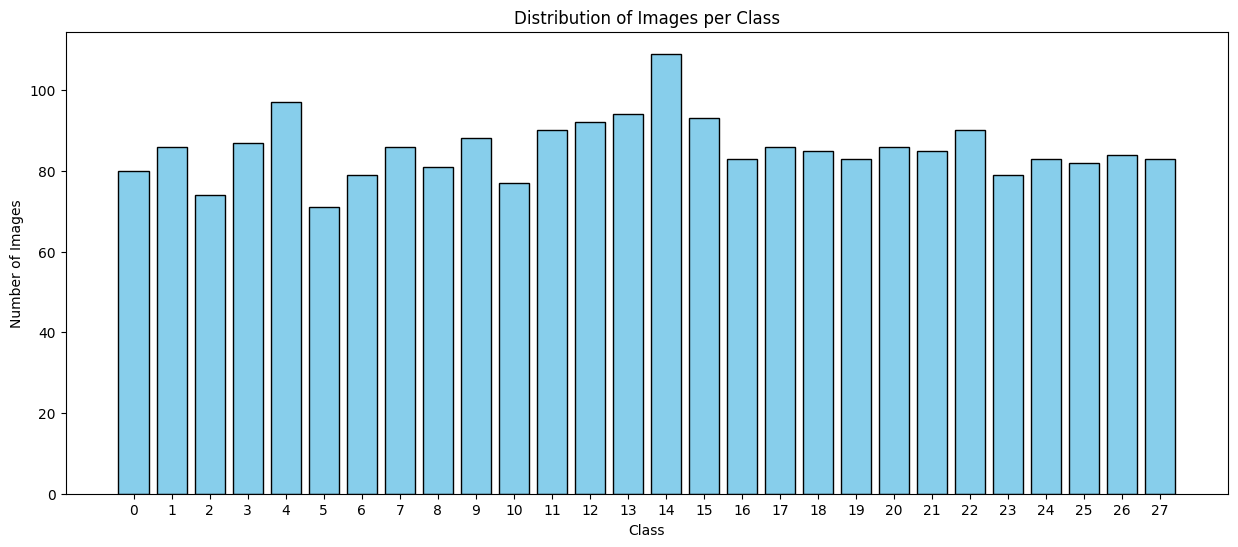

In [6]:
import os
import matplotlib.pyplot as plt

class_counts = {}

for filename in os.listdir(labels_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(labels_dir, filename)

        with open(file_path, 'r') as f:
            line = f.readline().strip()
            if line:
                class_id = int(line.split()[0])
                class_counts[class_id] = class_counts.get(class_id, 0) + 1

classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]

plt.figure(figsize=(15, 6))
plt.bar(classes, counts, color='skyblue', edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class')
plt.xticks(classes)
plt.show()

In [8]:
import cv2

output_dir = '/content/drive/My Drive/Computer Vision Project/Balanced_Dataset/train'

# Minimum count
limit = min(class_counts.values())
print(f"{limit} images per class.")

# Clip the data
saved_counts = {}

for filename in sorted(os.listdir(images_dir)):
    # Get the label
    txt_path = os.path.join(labels_dir, filename.replace('.jpg', '.txt'))
    if not os.path.exists(txt_path):
      continue

    with open(txt_path, 'r') as f:
        class_id = int(f.readline().split()[0])

    current_count = saved_counts.get(class_id, 0)

    if current_count < limit:

        img_path = os.path.join(images_dir, filename)
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, (128, 128))

        save_folder = os.path.join(output_dir, str(class_id))
        os.makedirs(save_folder, exist_ok=True)

        cv2.imwrite(os.path.join(save_folder, filename), img_resized)

        saved_counts[class_id] = current_count + 1


71 images per class.


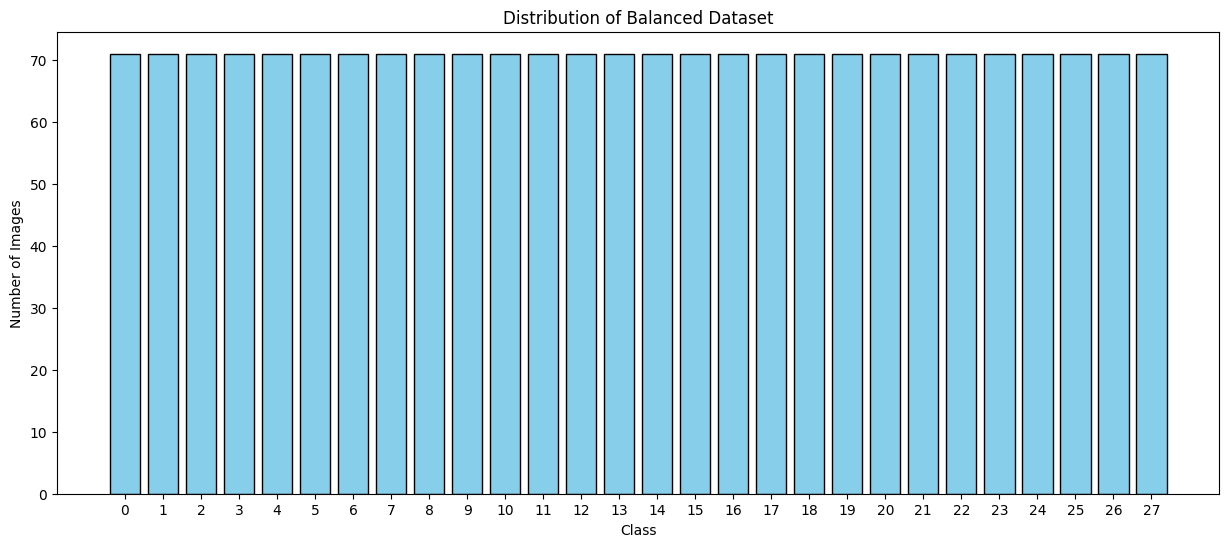

In [10]:
import os
import matplotlib.pyplot as plt

new_counts = {}

for folder_name in os.listdir(output_dir):
    folder_path = os.path.join(output_dir, folder_name)

    if os.path.isdir(folder_path):
        count = len(os.listdir(folder_path))
        new_counts[int(folder_name)] = count

classes = sorted(new_counts.keys())
counts = [new_counts[c] for c in classes]

plt.figure(figsize=(15, 6))
plt.bar(classes, counts, color='skyblue', edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Balanced Dataset')
plt.xticks(classes)
plt.show()

In [16]:
base_path = '/content/drive/My Drive/Computer Vision Project/unaugmented/416'

output_base = '/content/drive/My Drive/Computer Vision Project/Balanced_Dataset'

subsets = ['valid', 'test']

print("Starting organization of Validation and Test sets...")

for subset in subsets:

    images_dir = os.path.join(base_path, subset, 'images')
    labels_dir = os.path.join(base_path, subset, 'labels')

    output_dir = os.path.join(output_base, subset)

    all_files = sorted(os.listdir(images_dir))

    for filename in all_files:
        txt_name = filename.replace('.jpg', '.txt')
        txt_path = os.path.join(labels_dir, txt_name)

        if not os.path.exists(txt_path): continue

        with open(txt_path, 'r') as f:
            line = f.readline().strip()
            if not line: continue
            class_id = int(line.split()[0])

        img_path = os.path.join(images_dir, filename)
        img = cv2.imread(img_path)

        if img is not None:
            img_resized = cv2.resize(img, (128, 128))

            save_folder = os.path.join(output_dir, str(class_id))
            os.makedirs(save_folder, exist_ok=True)

            cv2.imwrite(os.path.join(save_folder, filename), img_resized)


Starting organization of Validation and Test sets...


In [11]:
import tensorflow as tf
import numpy as np
import os

balanced_train_path = '/content/drive/My Drive/Computer Vision Project/Balanced_Dataset/train'

# Images and Labels (One-Hot Encoding)
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    balanced_train_path,
    image_size= (128, 128),
    batch_size= 32,
    label_mode='categorical',
    shuffle=True
)

# Normalize
def normalize_data(image, label):
    norm_image = tf.cast(image, tf.float32) / 255.0
    return norm_image, label

train_ds = raw_train_ds.map(normalize_data)


Found 1988 files belonging to 28 classes.


In [17]:
for images_variable, labels_variable in train_ds.take(1):

    print(f"Tensor 1: Images")
    print(f"Shape: {images_variable.shape}")
    print("\nExample Data (First Image):\n")
    print(images_variable[0].numpy())

    print()

    print(f"Tensor 2: Labels")
    print(f"Shape: {labels_variable.shape}")
    print("\nExample Data (First Label ):\n")
    print(labels_variable[0].numpy())

Tensor 1: Images
Shape: (32, 128, 128, 3)

Example Data (First Image):

[[[0.5058824  0.68235296 0.84313726]
  [0.4745098  0.62352943 0.76862746]
  [0.85882354 0.95686275 1.        ]
  ...
  [0.3882353  0.65882355 0.92941177]
  [0.41960785 0.68235296 0.9607843 ]
  [0.42352942 0.68235296 0.972549  ]]

 [[0.3019608  0.47058824 0.6392157 ]
  [0.5882353  0.7254902  0.88235295]
  [0.7411765  0.83137256 0.9647059 ]
  ...
  [0.4392157  0.70980394 0.972549  ]
  [0.44313726 0.7058824  0.9843137 ]
  [0.43529412 0.69803923 0.9764706 ]]

 [[0.5411765  0.68235296 0.8862745 ]
  [0.5294118  0.6509804  0.8352941 ]
  [0.6745098  0.7607843  0.90588236]
  ...
  [0.42745098 0.69803923 0.9607843 ]
  [0.43529412 0.69803923 0.972549  ]
  [0.4        0.6509804  0.92941177]]

 ...

 [[0.6666667  0.6156863  0.5529412 ]
  [0.67058825 0.61960787 0.5568628 ]
  [0.6901961  0.6392157  0.57254905]
  ...
  [0.17254902 0.11764706 0.08235294]
  [0.16078432 0.10588235 0.07058824]
  [0.14901961 0.09411765 0.05882353]]

 [